## **code created by Murat Khidoyatov at Yale University**

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# **Define a function for the variable coefficients, which can depend on x, y, and their derivatives**

In [29]:
def coeff_n(x, y, dy_dx): 
    return 1  # This can be changed to any function of x, y, or dy_dx. Change as needed 

**Always use torch for the math functions instead of the numpy**

In [30]:
def coeff_1(x, y, dy_dx):
    return -1  # Example: Can be x, y, or some nonlinear function. Change as needed 

*or you can just pass down **return np.sin(y)** if your coefficient for y' is sin(y)*

In [31]:
def coeff_0(x, y, dy_dx):
    return torch.sin(x)  # Example: Can be x, y, or some nonlinear function.  Change as needed 

# **Apply Boundary Conditions**

In [32]:
x_range = (0, 2 * np.pi)  # Range for x
boundary_conditions = [
    (0.0, 0.0),  # Example: y(0) = 0. Change as needed
    (2 * np.pi, 0.0),  # Example: y(2*pi) = 0. Change as needed 
]

# **Learning rate and number of epochs**

In [33]:
learning_rate = 0.001 
num_epochs = 1000 

# **Define the neural network structure**

In [34]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.hidden_layer_1 = nn.Linear(1, 200)
        self.hidden_layer_2 = nn.Linear(200, 200)
        self.hidden_layer_3 = nn.Linear(200, 200)
        self.output_layer = nn.Linear(200, 1)

    def forward(self, x):
        x = torch.sigmoid(self.hidden_layer_1(x))
        x = torch.sigmoid(self.hidden_layer_2(x))
        x = torch.sigmoid(self.hidden_layer_3(x))
        x = self.output_layer(x)
        return x

# **Define the ODE residual function to train NN model**

In [35]:
def f_ode(x, net):
    y = net(x)  # Neural network approximation of y(x)
    dy_dx = torch.autograd.grad(y, x, torch.ones_like(x), create_graph=True)[0]  # dy/dx
    d2y_dx2 = torch.autograd.grad(dy_dx, x, torch.ones_like(x), create_graph=True)[0]  # d2y/dx2

    # Variable coefficients (these can depend on x, y, dy/dx)
    coeff_n_val = coeff_n(x, y, dy_dx)
    coeff_1_val = coeff_1(x, y, dy_dx)
    coeff_0_val = coeff_0(x, y, dy_dx)

    # General form: coeff_n * y'' + coeff_1 * y' + coeff_0 * y = 0
    ode_residual = coeff_n_val * d2y_dx2 + coeff_1_val * dy_dx + coeff_0_val * y
    
    return ode_residual

# **Apply boundary conditions to train NN model**

In [36]:
def apply_boundary_conditions(net, boundary_conditions):
    bc_residuals = []
    for bc in boundary_conditions:
        x_bc = torch.tensor([[bc[0]]], requires_grad=True)  # Boundary point at x = bc[0]
        y_bc = net(x_bc)  # Predict y(bc[0])
        bc_residual = y_bc - bc[1]  # The residual is y(bc[0]) - bc[1]
        bc_residuals.append(bc_residual)
    return torch.sum(torch.stack([bc**2 for bc in bc_residuals]))  # Sum of residuals squared


# **Training the network**

In [37]:
def train(net, optimizer, x_range, boundary_conditions, num_epochs=1000):
    x_min, x_max = x_range
    for epoch in range(num_epochs):
        optimizer.zero_grad()  # Reset gradients
        
        # Sample points in the domain x
        x = torch.linspace(x_min, x_max, 100).view(-1, 1)
        x.requires_grad = True  # Enable gradient tracking for these inputs
        
        # Compute the ODE residual
        ode_residual = f_ode(x, net)
        
        # Compute the boundary condition residuals
        bc_residual = apply_boundary_conditions(net, boundary_conditions)
        
        # Define the loss as the sum of the ODE residuals and boundary condition residuals
        loss = torch.mean(ode_residual**2) + bc_residual
        
        # Perform backpropagation and optimization step
        loss.backward()
        optimizer.step()
        
        # Print the loss every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    # Calculate and display the final accuracy and loss after training
    final_loss = loss.item()
    accuracy = calculate_accuracy(net, boundary_conditions)
    print(f'\nFinal Loss: {final_loss}')
    print(f'Accuracy in % : {accuracy}')


> **function to calculate accuracy based on boundary conditions**

In [38]:
def calculate_accuracy(net, boundary_conditions):
    total_error = 0
    max_bc_value = max([abs(bc[1]) for bc in boundary_conditions])
    if max_bc_value == 0:
        max_bc_value = 1.0

    for bc in boundary_conditions:
        x_bc = torch.tensor([[bc[0]]], dtype=torch.float32)
        y_bc = net(x_bc)
        total_error += (y_bc.item() - bc[1])**2

    mse = total_error / len(boundary_conditions)
    accuracy_percentage = 100 - ((mse / max_bc_value) * 100)
    return accuracy_percentage


> **Function to visualize the solution of the ODE learned by the NN**

In [39]:
def visualize_solution(net, x_range):
    x_min, x_max = x_range
    x_values = np.linspace(x_min, x_max, 100)
    x_tensor = torch.tensor(x_values, dtype=torch.float32).view(-1, 1)
    
    y_pred = net(x_tensor).detach().numpy()
    
    # Plotting the predicted solution
    plt.plot(x_values, y_pred, label="NN Solution")
    plt.xlabel("x")
    plt.ylabel("y(x)")
    plt.title("Solution of the ODE learned by the Neural Network")
    plt.legend()
    plt.grid(True)
    plt.show()

# **Initialize and train the NN**

In [40]:
# Initialize the network and optimizer
net = Network()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [41]:
# Train the network
train(net, optimizer, x_range, boundary_conditions, num_epochs)

Epoch 0, Loss: 0.035659536719322205
Epoch 10, Loss: 0.011862030252814293
Epoch 20, Loss: 0.003999337553977966
Epoch 30, Loss: 0.0015730959130451083
Epoch 40, Loss: 0.00042854741332121193
Epoch 50, Loss: 2.8187840143800713e-05
Epoch 60, Loss: 2.5678513338789344e-05
Epoch 70, Loss: 4.2208979721181095e-05
Epoch 80, Loss: 5.585935127783159e-07
Epoch 90, Loss: 5.4804277169751e-06
Epoch 100, Loss: 1.0576405884421547e-07
Epoch 110, Loss: 4.2965018565155333e-07
Epoch 120, Loss: 2.8811865604438935e-07
Epoch 130, Loss: 8.796841655112075e-08
Epoch 140, Loss: 3.9642440441411964e-08
Epoch 150, Loss: 3.325630615336195e-08
Epoch 160, Loss: 3.2380970793610686e-08
Epoch 170, Loss: 3.2034080277298926e-08
Epoch 180, Loss: 3.172650764327045e-08
Epoch 190, Loss: 3.1359235208583414e-08
Epoch 200, Loss: 3.0956243790569715e-08
Epoch 210, Loss: 3.057238018300268e-08
Epoch 220, Loss: 3.0246148696733144e-08
Epoch 230, Loss: 2.9935062428876336e-08
Epoch 240, Loss: 2.9618972163802937e-08
Epoch 250, Loss: 2.9328560

# **Visualize the solution of the NN** 

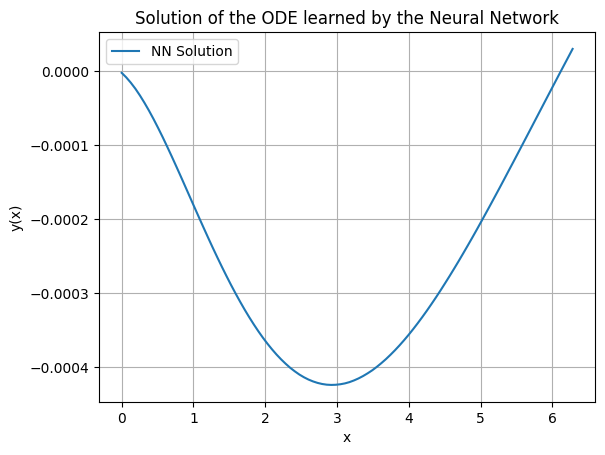

In [42]:
visualize_solution(net, x_range)